# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Liying Ma

**ID**: Lm698

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [77]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/BEE4750/hws/hw3-lm698-test`


In [79]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

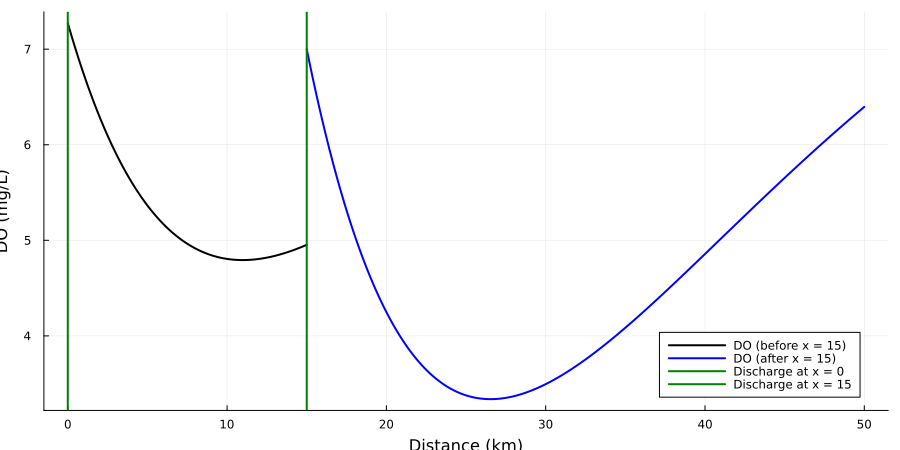

In [189]:
# Plot the dissolved oxygen concenrtation
# Reference 1
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

# Function to calculate the concentration of mixing point from two sources
function mixing_calc(Q1, Q2, C0_1, C0_2, B0_1, B0_2, N0_1, N0_2)
    Q_total = Q1 + Q2
    C0_mix = (Q1 * C0_1 + Q2 * C0_2) / Q_total
    B0_mix = (Q1 * B0_1 + Q2 * B0_2) / Q_total
    N0_mix = (Q1 * N0_1 + Q2 * N0_2) / Q_total
    return Q_total, C0_mix, B0_mix, N0_mix
end

# set river properties
ka = 0.55 # reareaction rate
kc = 0.35 # CBOD decay rate
kn = 0.25 # CNOD decay rate

C0 = 6.2 # initial DO concenrtation
B0 = 9 # initial BOD concenrtation
N0 = 7 # initial NBOD concenrtation

Cs = 10 # saturated dissolved Oxygen concenrtation
U = 6 # river velocity

x = 0:50 # distance

# evaluate model over all x's
# Discharge locations and distances
x_discharge_1 = 0  # location of the first discharge
x_discharge_2 = 15  # location of the second discharge
x_total = 50  # total distance to simulate

# River inflow initial conditions
C0_r = 7.5
B0_r = 5  
N0_r = 5
Q_r = 100000

# Waste stream 1 characteristics
C0_1 = 5
B0_1 = 50
N0_1 = 35
Q_1 = 10000

# Waste stream 2 characteristics
C0_2 = 5
B0_2 = 25
N0_2 = 35
Q_2 = 15000

# Mix the first waste stream into the river at x = 0
Q_total_1, C0_mix1, B0_mix1, N0_mix1 = mixing_calc(Q_r, Q_1, C0_r, C0_1, B0_r, B0_1, N0_r, N0_1)

# Simulate from x = 0 to x = 15 (before the second discharge)
x1 = 0:0.1:x_discharge_2
do_out1 = (y -> do_simulate(y, C0_mix1, B0_mix1, N0_mix1, ka, kc, kn, Cs, U)).(x1)

# Get concentrations after the first discharge at x = 15
C_end1 = do_out1[end][1]
B_end1 = do_out1[end][2]
N_end1 = do_out1[end][3]

# Mix the second waste stream into the river at x = 15
Q_total_2, C0_mix2, B0_mix2, N0_mix2 = mixing_calc(Q_total_1, Q_2, C0_mix1, C0_2, B0_mix1, B0_2, N0_mix1, N0_2)

# Simulate from x = 15 to x = 50 (after the second discharge)
x2 = x_discharge_2:0.1:x_total
do_out2 = (y -> do_simulate(y - x_discharge_2, C0_mix2, B0_mix2, N0_mix2, ka, kc, kn, Cs, U)).(x2)

# Get concentrations after the second discharge at x = 50
C_end2 = do_out2[end][1]
B_end2 = do_out2[end][2]
N_end2 = do_out2[end][3]

# Plot results
p1 = plot(; ylabel="DO (mg/L)", xlabel="Distance (km)")
plot!(p1, x1, [d[1] for d in do_out1], color=:black, linewidth=2, label="DO (before x = 15)")
plot!(p1, x2, [d[1] for d in do_out2], color=:blue, linewidth=2, label="DO (after x = 15)")
plot!(size=(900, 450))

vline!([0], color=:green, linewidth=2, label="Discharge at x = 0")
vline!([15], color=:green, linewidth=2, label="Discharge at x = 15")


In [233]:
# Find the minimum DO concenrtation
DO_min = min(findmin([d[1] for d in do_out1])[1], findmin([d[1] for d in do_out2])[1])
println("The minimum DO value is ", DO_min ," mg/L.")

The minimum DO value is 3.338174081015101 mg/L.


In [242]:
# Find the minimum level of treatment in the first discharge site
function percent_removal_(B0, N0, treatment_percent)
    B0_treated = B0 * (1 - treatment_percent / 100)
    N0_treated = N0 * (1 - treatment_percent / 100)
    return B0_treated, N0_treated
end

treatment_levels = 0:1:100

for i in treatment_levels
    # Calculate the new concentrations
    B0_treated, N0_treated = percent_removal_(B0_1, N0_1, i)
    # Reapeat the process
    # Mix the first waste stream into the river at x = 0
    Q_total_1, C0_mix1, B0_mix1, N0_mix1 = mixing_calc(Q_r, Q_1, C0_r, C0_1, B0_r, B0_treated, N0_r, N0_treated)

    # Simulate from x = 0 to x = 15 (before the second discharge site)
    x1 = 0:0.1:x_discharge_2
    do_out1_new = (y -> do_simulate(y, C0_mix1, B0_mix1, N0_mix1, ka, kc, kn, Cs, U)).(x1)

    # Get concentrations after the first discharge at x = 15
    C_end1 = do_out1[end][1]
    B_end1 = do_out1[end][2]
    N_end1 = do_out1[end][3]

    # Mix the second waste stream into the river at x = 15
    Q_total_2, C0_mix2, B0_mix2, N0_mix2 = mixing_calc(Q_total_1, Q_2, C0_mix1, C0_2, B0_mix1, B0_2, N0_mix1, N0_2)

    # Simulate from x = 15 to x = 50 (after the second discharge site)
    x2 = x_discharge_2:0.1:x_total
    do_out2_new = (y -> do_simulate(y - x_discharge_2, C0_mix2, B0_mix2, N0_mix2, ka, kc, kn, Cs, U)).(x2)

    # Get all DO concentrations along the river (combining both segments)
    C_full = vcat([d[1] for d in do_out1_new], [d[1] for d in do_out2_new]) # Reference 2

    # Set up the minimum condition
    if minimum(C_full) >= 4
        println("Solution found: Treatment level $i%, Minimum DO = $(minimum(C_full)) mg/L")
        return i, minimum(C_full)
    end
end


Solution found: Treatment level 40%, Minimum DO = 4.016057750868834 mg/L


(40, 4.016057750868834)

In [195]:
# Find the minimum level of treatment in the second discharge site
treatment_levels = 0:1:100

for i in treatment_levels
    # Calculate the new concentrations
    B0_treated, N0_treated = percent_removal_(B0_2, N0_2, i)
    # Reapeat the process
    # Mix the first waste stream into the river at x = 0
    Q_total_1, C0_mix1, B0_mix1, N0_mix1 = mixing_calc(Q_r, Q_1, C0_r, C0_1, B0_r, B0_1, N0_r, N0_1)

    # Simulate from x = 0 to x = 15 (before the second discharge)
    x1 = 0:0.1:x_discharge_2
    do_out1_new = (y -> do_simulate(y, C0_mix1, B0_mix1, N0_mix1, ka, kc, kn, Cs, U)).(x1)

    # Get concentrations after the first discharge at x = 15
    C_end1 = do_out1[end][1]
    B_end1 = do_out1[end][2]
    N_end1 = do_out1[end][3]

    # Mix the second waste stream into the river at x = 15
    Q_total_2, C0_mix2, B0_mix2, N0_mix2 = mixing_calc(Q_total_1, Q_2, C0_mix1, C0_2, B0_mix1, B0_treated, N0_mix1, N0_treated)

    # Simulate from x = 15 to x = 50 (after the second discharge)
    x2 = x_discharge_2:0.1:x_total
    do_out2_new = (y -> do_simulate(y - x_discharge_2, C0_mix2, B0_mix2, N0_mix2, ka, kc, kn, Cs, U)).(x2)

    # Get all DO concentrations along the river (combining both segments)
    C_full = vcat([d[1] for d in do_out1_new], [d[1] for d in do_out2_new])

    # Set up the minimum condition
    if minimum(C_full) >= 4
        println("Solution found: Treatment level $i%, Minimum DO = $(minimum(C_full)) mg/L")
        return i, minimum(C_full)
    end
end


Solution found: Treatment level 36%, Minimum DO = 4.010865990069725 mg/L


(36, 4.010865990069725)

In [196]:
# Find the minimum level of treatment of both discharge sites
treatment_levels = 0:1:100

for i in treatment_levels
    # Calculate the new concentrations
    B0_treated_1, N0_treated_1 = percent_removal_(B0_1, N0_1, i)
    B0_treated_2, N0_treated_2 = percent_removal_(B0_2, N0_2, i)
    # Reapeat the process
    # Mix the first waste stream into the river at x = 0
    Q_total_1, C0_mix1, B0_mix1, N0_mix1 = mixing_calc(Q_r, Q_1, C0_r, C0_1, B0_r, B0_treated_1, N0_r, N0_treated_1)

    # Simulate from x = 0 to x = 15 (before the second discharge)
    x1 = 0:0.1:x_discharge_2
    do_out1_new = (y -> do_simulate(y, C0_mix1, B0_mix1, N0_mix1, ka, kc, kn, Cs, U)).(x1)

    # Get concentrations after the first discharge at x = 15
    C_end1 = do_out1[end][1]
    B_end1 = do_out1[end][2]
    N_end1 = do_out1[end][3]

    # Mix the second waste stream into the river at x = 15
    Q_total_2, C0_mix2, B0_mix2, N0_mix2 = mixing_calc(Q_total_1, Q_2, C0_mix1, C0_2, B0_mix1, B0_treated_2, N0_mix1, N0_treated_2)

    # Simulate from x = 15 to x = 50 (after the second discharge)
    x2 = x_discharge_2:0.1:x_total
    do_out2_new = (y -> do_simulate(y - x_discharge_2, C0_mix2, B0_mix2, N0_mix2, ka, kc, kn, Cs, U)).(x2)

    # Get all DO concentrations along the river (combining both segments)
    C_full = vcat([d[1] for d in do_out1_new], [d[1] for d in do_out2_new])

    # Set up the minimum condition
    if minimum(C_full) >= 4
        println("Solution found: Treatment level $i%, Minimum DO = $(minimum(C_full)) mg/L")
        return i, minimum(C_full)
    end
end

Solution found: Treatment level 19%, Minimum DO = 4.015192235099235 mg/L


(19, 4.015192235099235)

### Answer
-   The minimum DO value is 3.34 mg/L.
-   The minimum percent removal of organic waste in waste stream 1 only, is
    40%, and the minimum DO concentreation is 4.016 mg/L; The minimum 
    percent removal of organic waste in waste stream 2 only, is 36%, 
    and the minimum DO concentration is 4.011 mg/L.
-   Eventhough the percent removal of waste stream 2 is lower than the percent
    removal of waste stream 1, the flow rate of waste stream 2 is higher than
    waste stream 1, which means the amount of water to be treated will be greater in
    stream 2. If we considering the cost of treatment, this might have a higher cost.
    After calculation, I found that if treat both of the waste stream equally, the 
    percent removal is 19%, which is lower than treat each of them alone. Therefore, 
    I would opt to treat both of the streams equally. However, we might want to conduct 
    a cost analysis that includes infrastructure upgrade costs, operational costs, 
    and long-term maintenance considerations.

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [197]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

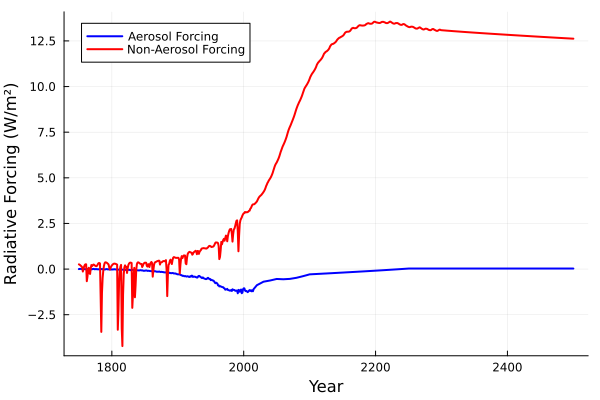

In [198]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

The Temperature in 2100 relative to 1750: 6.027123866872981°C


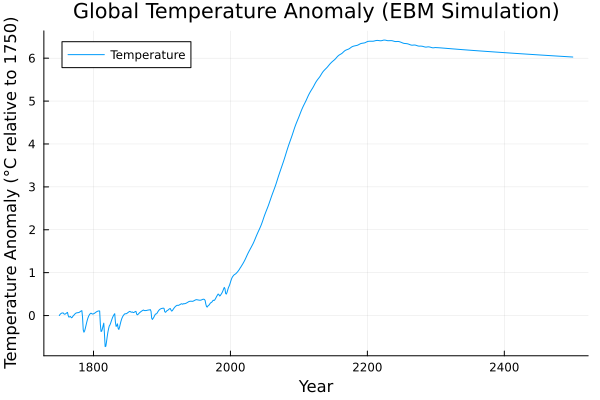

In [246]:
# Constants
c = 4.184 * 10^6 #J/K/m^2
d = 86 #m
lambda = 2.1 #°C/(W/m^2)
alpha = 0.8
dt = 31_558_152 #s

# Function to calculate the total radiative force
function total_radiative_force(non_aerosol, aerosol, alpha)
    return non_aerosol + alpha * aerosol
end

# Initial condition
T_0 = 0.0

# Time step and simulation setup
years = 1750:2500  
num_years = length(years)
T = zeros(num_years)  
T[1] = T_0  # set the initial temperature

# Function to simulate temperature evolution using EBM
function simulate_temperature(T, non_aerosol, aerosol, alpha, lambda, c, d, dt, num_years)
    for n in 1:num_years-1
        F_total = total_radiative_force(non_aerosol[n], aerosol[n], alpha)
        T[n+1] = T[n] + (dt / (c * d)) * (F_total - lambda * T[n])
    end
    return T
end

T_result = simulate_temperature(T, forcing_non_aerosol, forcing_aerosol, alpha, lambda, c, d, dt, num_years)

println("The Temperature in 2100 relative to 1750: $(T[end])", "°C")

plot(years, T_result, xlabel="Year", ylabel="Temperature Anomaly (°C relative to 1750)", 
        title="Global Temperature Anomaly (EBM Simulation)", label="Temperature")

Expected Temperature in 2100 relative to 1750: 6.119444954301903°C
95% Confidence Interval: [4.282578710204336, 8.505691671059013]


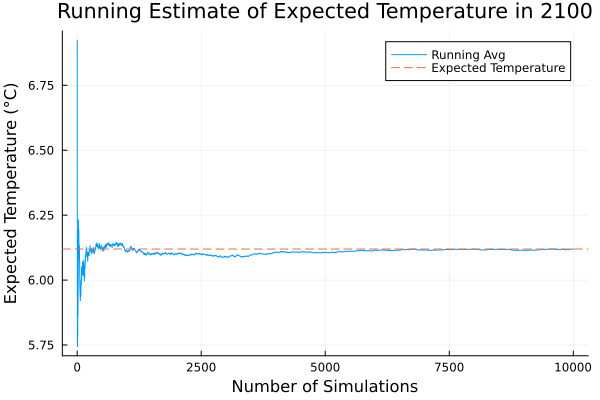

In [266]:
# Monte Carlo simulation parameters
num_simulations = 10_000

# LogNormal distribution for lambda
lambda_dist = LogNormal(log(2.1), log(2) / 4)

# Storage for temperatures in 2100
T_2100_samples = zeros(num_simulations)

# Perform Monte Carlo simulation
for i in 1:num_simulations

    lambda_sample = rand(lambda_dist)

    T_mc = zeros(num_years)
    T_mc[1] = T_0
    
    T_mc_result = simulate_temperature(T_mc, forcing_non_aerosol, forcing_aerosol, alpha, lambda_sample, c, d, dt, num_years)
    T_2100_samples[i] = T_mc_result[end]
end

# Compute expected value and 95% confidence interval
# Refernce 3
mean_T_2100 = mean(T_2100_samples)
lower_CI = quantile(T_2100_samples, 0.025)
upper_CI = quantile(T_2100_samples, 0.975)

println("Expected Temperature in 2100 relative to 1750: $mean_T_2100", "°C")
println("95% Confidence Interval: [$lower_CI, $upper_CI]")

# Compute the cumulative mean of the Monte Carlo results
cumulative_mean = zeros(num_simulations)
cumulative_sum = 0  # Start cumulative sum at 0

for i in 1:num_simulations
    cumulative_sum += T_2100_samples[i]  
    cumulative_mean[i] = cumulative_sum / i 
end

# Plot the running cumulative mean of expected temperatures in 2100
plot(1:num_simulations, cumulative_mean, title="Running Estimate of Expected Temperature in 2100",
     xlabel="Number of Simulations", ylabel="Expected Temperature (°C)",
     label="Running Avg", legend=true, grid=true)

hline!([mean(T_2100_samples)], label="Expected Temperature", linestyle=:dash)

### Answer
This estimate has a relative error of approximately 1.5% compared to the result from the simulation, which indicates a very close match to the expected value. Furthermore, the plot of the running cumulative mean shows a clear convergence towards a stable value, suggesting that the sample set used in the Monte Carlo simulation is sufficient.

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.

Reference 1: https://viveks.me/environmental-systems-analysis/slides/lecture04-2-dissolved-oxygen.html#/simulation-outputs-sag-curve

Reference 2: https://discourse.julialang.org/t/how-to-merge-arrays-in-julia/51520/5

Reference 3: https://discourse.julialang.org/t/how-to-compute-calculate-a-confidence-interval-ci/74794/2